<h1 style="font-size:30px">Patient Treatment Classification</h1>

# 1. Context
In hospitals, medical treatments and surgeries can be categorized into inpatient and outpatient procedures.<br> For patients, it is important to understand the difference between these two types of care, because they impact the length of a patient’s stay in a medical facility and the cost of a procedure.

The difference between an inpatient and outpatient care is how long a patient must remain in the facility where they have the procedure done.

Inpatient care requires overnight hospitalization. Patients must stay at the medical facility where their procedure was done (which is usually a hospital) for at least one night. During this time, they remain under the supervision of a nurse or doctor.

Patients receiving outpatient care do not need to spend a night in a hospital.

# 2. About Data
The dataset contains Electronic Health Record predictions collected from a private Hospital in Indonesia.
- HAEMATOCRIT : Patient laboratory test result of haematocrit

- HAEMOGLOBINS : Patient laboratory test result of haemoglobins

- ERYTHROCYTE : Patient laboratory test result of erythrocyte

- LEUCOCYTE : Patient laboratory test result of leucocyte

- THROMBOCYTE : Patient laboratory test result of thrombocyte

- MCH : Patient laboratory test result of MCH

- MCHC : Patient laboratory test result of MCHC

- MCV : Patient laboratory test result of MCV

- AGE : Patient age

- SEX : Patient gender



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

In [2]:
# Load dataset into the memory

data = pd.read_csv('/content/data-ori.csv')
data.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out


Train : 80% of data<br>
Test : 20% of data

In [3]:
# Label encoding
# (1=in care patient), (0=out care patient)
data['SOURCE'] = data.SOURCE.replace({"in":1, 'out':0})


# get all the features
features = [feat for feat in data.columns if feat !='SOURCE']

X = data[features] # feature set
y = data['SOURCE'] # target

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# train and test datasets dimensions
X_train.shape, X_test.shape

((3529, 10), (883, 10))

### Dataset Overview

In [4]:
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns")

num_features = [feat for feat in features if data[feat].dtype != object]
cat_features = [feat for feat in features if data[feat].dtype == object]

print(f"Total number of features : {len(features)}")
print(f"Number of numerical features : {len(num_features)}")
print(f"Number of categorical features : {len(cat_features)}\n")

The dataset contains 4412 rows and 11 columns
Total number of features : 10
Number of numerical features : 9
Number of categorical features : 1



In [5]:
# Show the percentage of missing values in each feature

data.isna().mean().to_frame(name='Missing %')

,Missing %
HAEMATOCRIT,0.0
HAEMOGLOBINS,0.0
ERYTHROCYTE,0.0
LEUCOCYTE,0.0
THROMBOCYTE,0.0
MCH,0.0
MCHC,0.0
MCV,0.0
AGE,0.0
SEX,0.0


Observation : We didn't find any missing values.

### Unique values

In [6]:
# To count number unique values in each feature

data.nunique().to_frame(name='# of unique values')

,# of unique values
HAEMATOCRIT,326
HAEMOGLOBINS,128
ERYTHROCYTE,433
LEUCOCYTE,276
THROMBOCYTE,554
MCH,189
MCHC,105
MCV,406
AGE,95
SEX,2


##Univariate analysis
Exploring each feature individually


### Target
name : SOURCE<br>
There are two classes in the target
- 0 : Outcare patient
- 1 : Incare patient

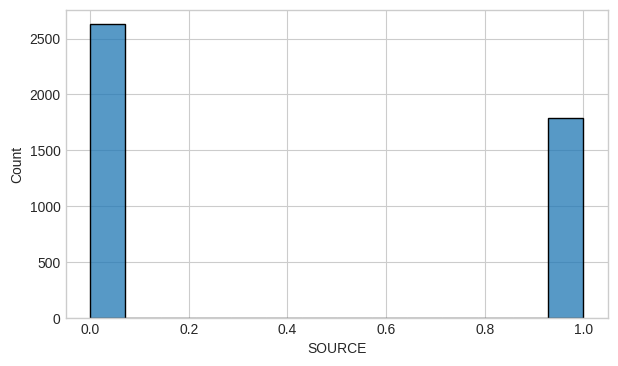

In [7]:
# Target distribution

plt.figure(figsize=(7,4))
fig = sns.histplot(x='SOURCE', data=data)

In [8]:
# Check no. of data points for each class

data.SOURCE.value_counts().to_frame(name='Count')

,Count
SOURCE,
0,2628
1,1784


Observation :
- data points belongs to class 0 : 2628
- data points belongs to class 1 : 1784
- Not an imbalanced dataset

### Numerical features
names :
- HAEMATOCRIT
- HAEMOGLOBINS
- ERYTHROCYTE
- LEUCOCYTE
- THROMBOCYTE
- MCH
- MCHC
- MCV
- AGE

In [9]:
# Describe statistics for each numerical features

data[num_features].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


#### Box plot

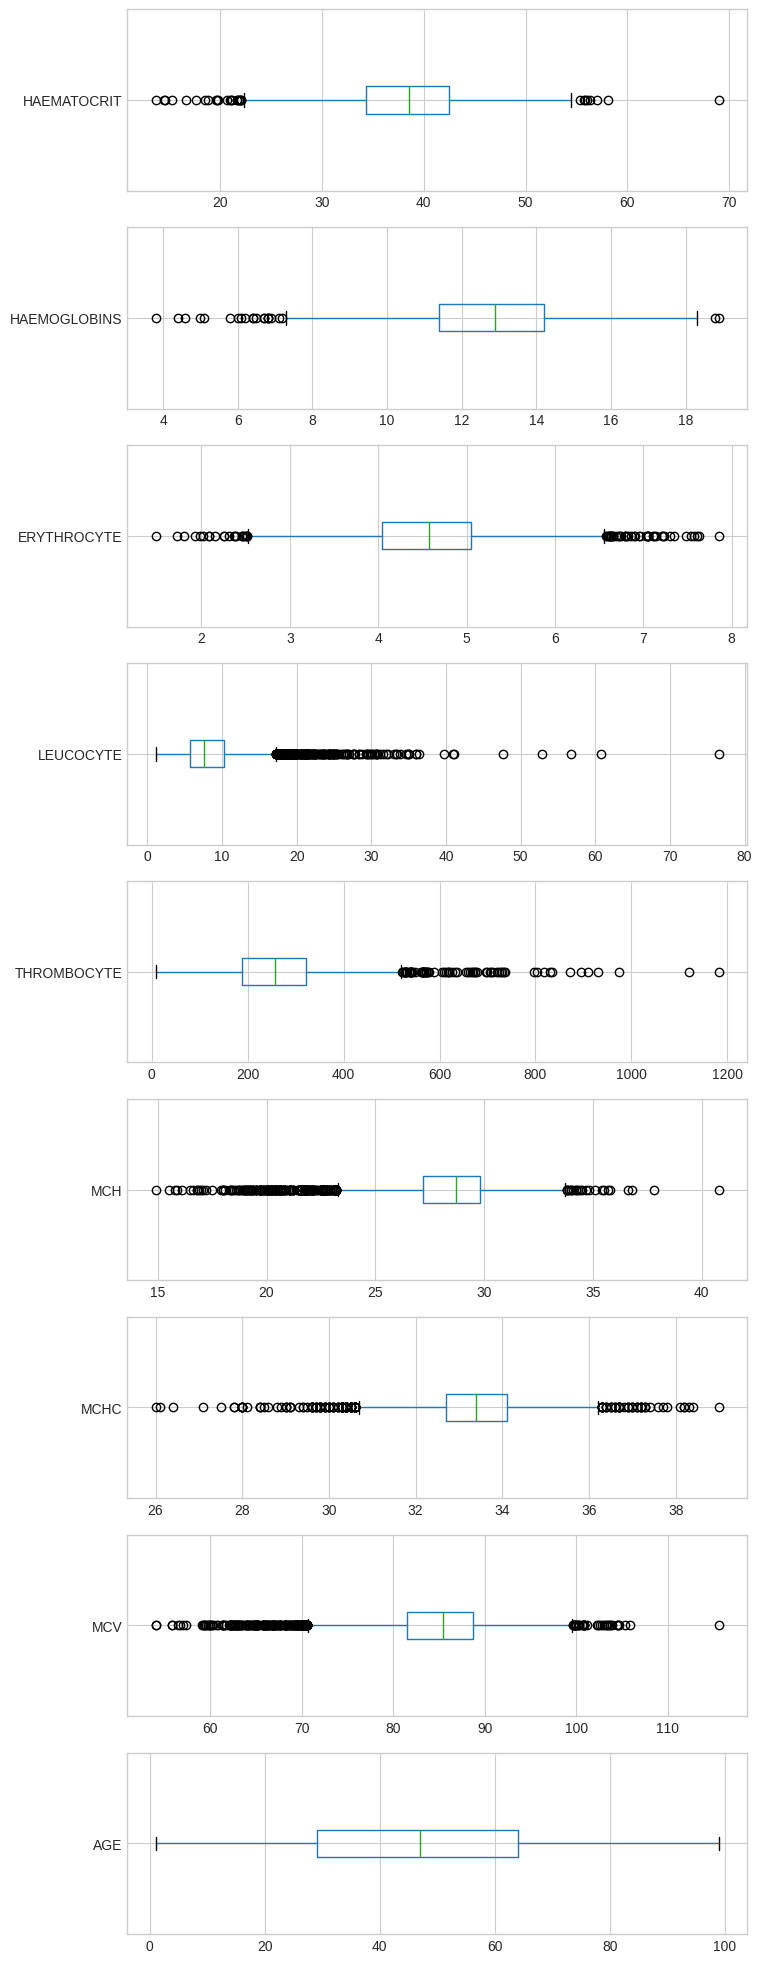

In [10]:
# Boxplot for each numerical feature

fig, axes = plt.subplots(9, 1, figsize=(8, 25))
for i, c in enumerate(num_features):
    f = data[[c]].boxplot(ax=axes[i], vert=False)

##### Density plot

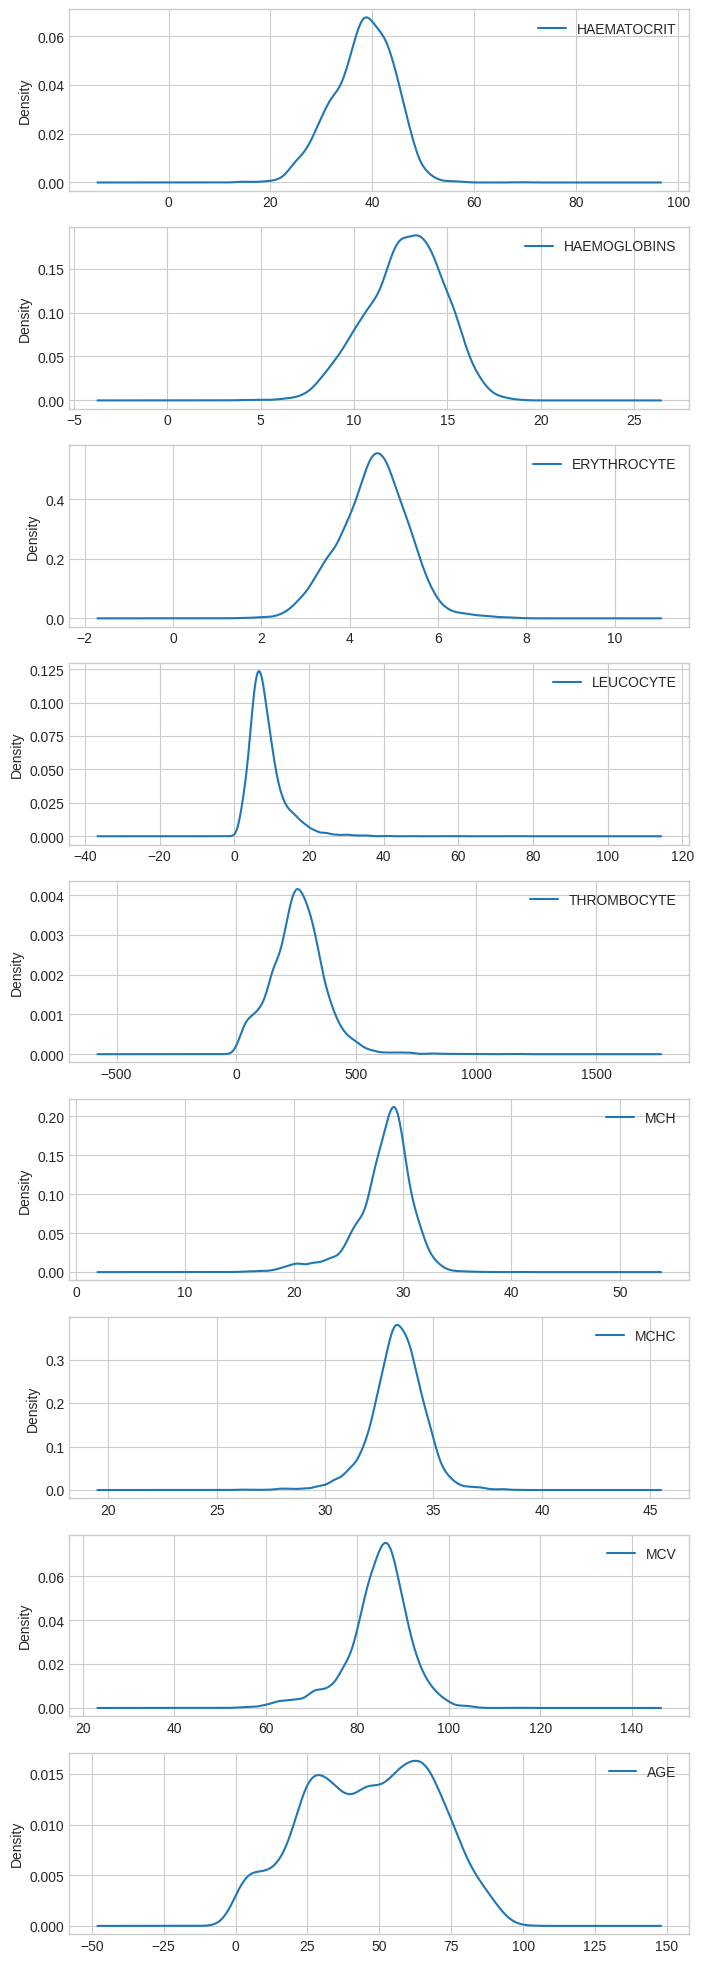

In [11]:
# Kernel Density Estimation plot for each numerical feature

fig, axes = plt.subplots(9, 1, figsize=(8, 25))
for i, c in enumerate(num_features):
    f = data[[c]].plot(kind='kde',ax=axes[i])

Observations:
- Few outliers are present in some numerical features
- Most of the features follows the Gaussian distribution (approx.)

### Categorical feature(s)
name : SEX<br>
labels : F, M

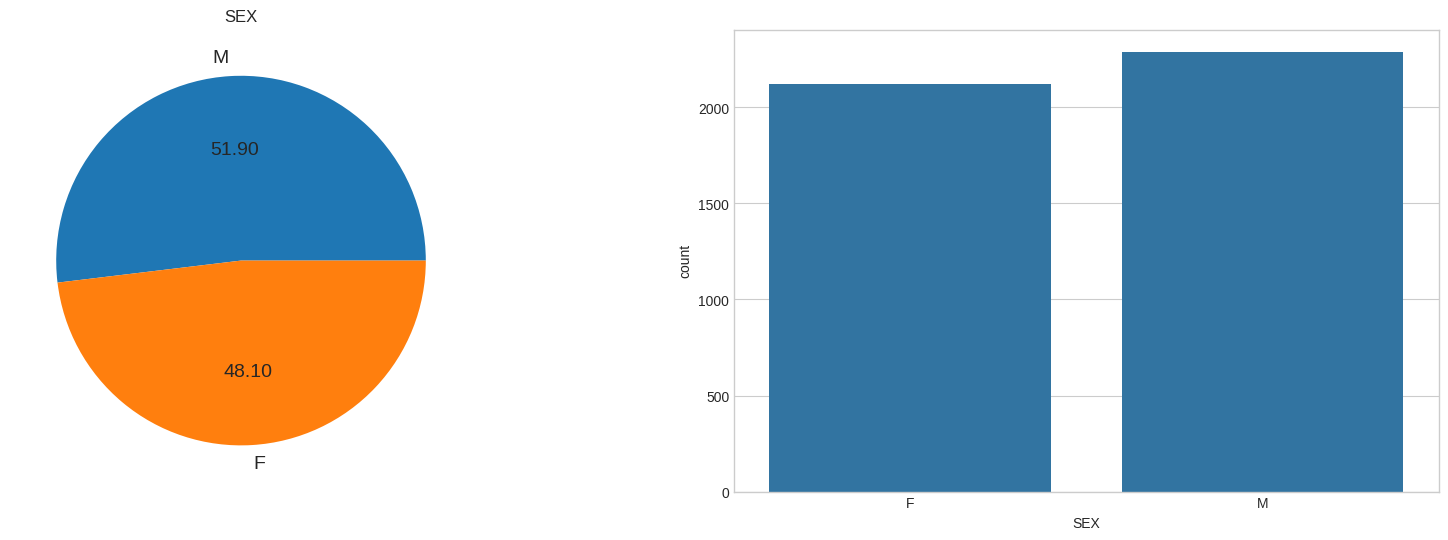

In [12]:
# Bar and count plot for Categorical feature
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
df = data['SEX'].value_counts()
barplot = df.plot(kind='pie', ax=axes[0], title='SEX', autopct="%.2f", fontsize=14, ylabel='')
countplot = sns.countplot(x='SEX', data=data, ax=axes[1])

## Bivariate analysis

### Numerical features

#### KDE plot

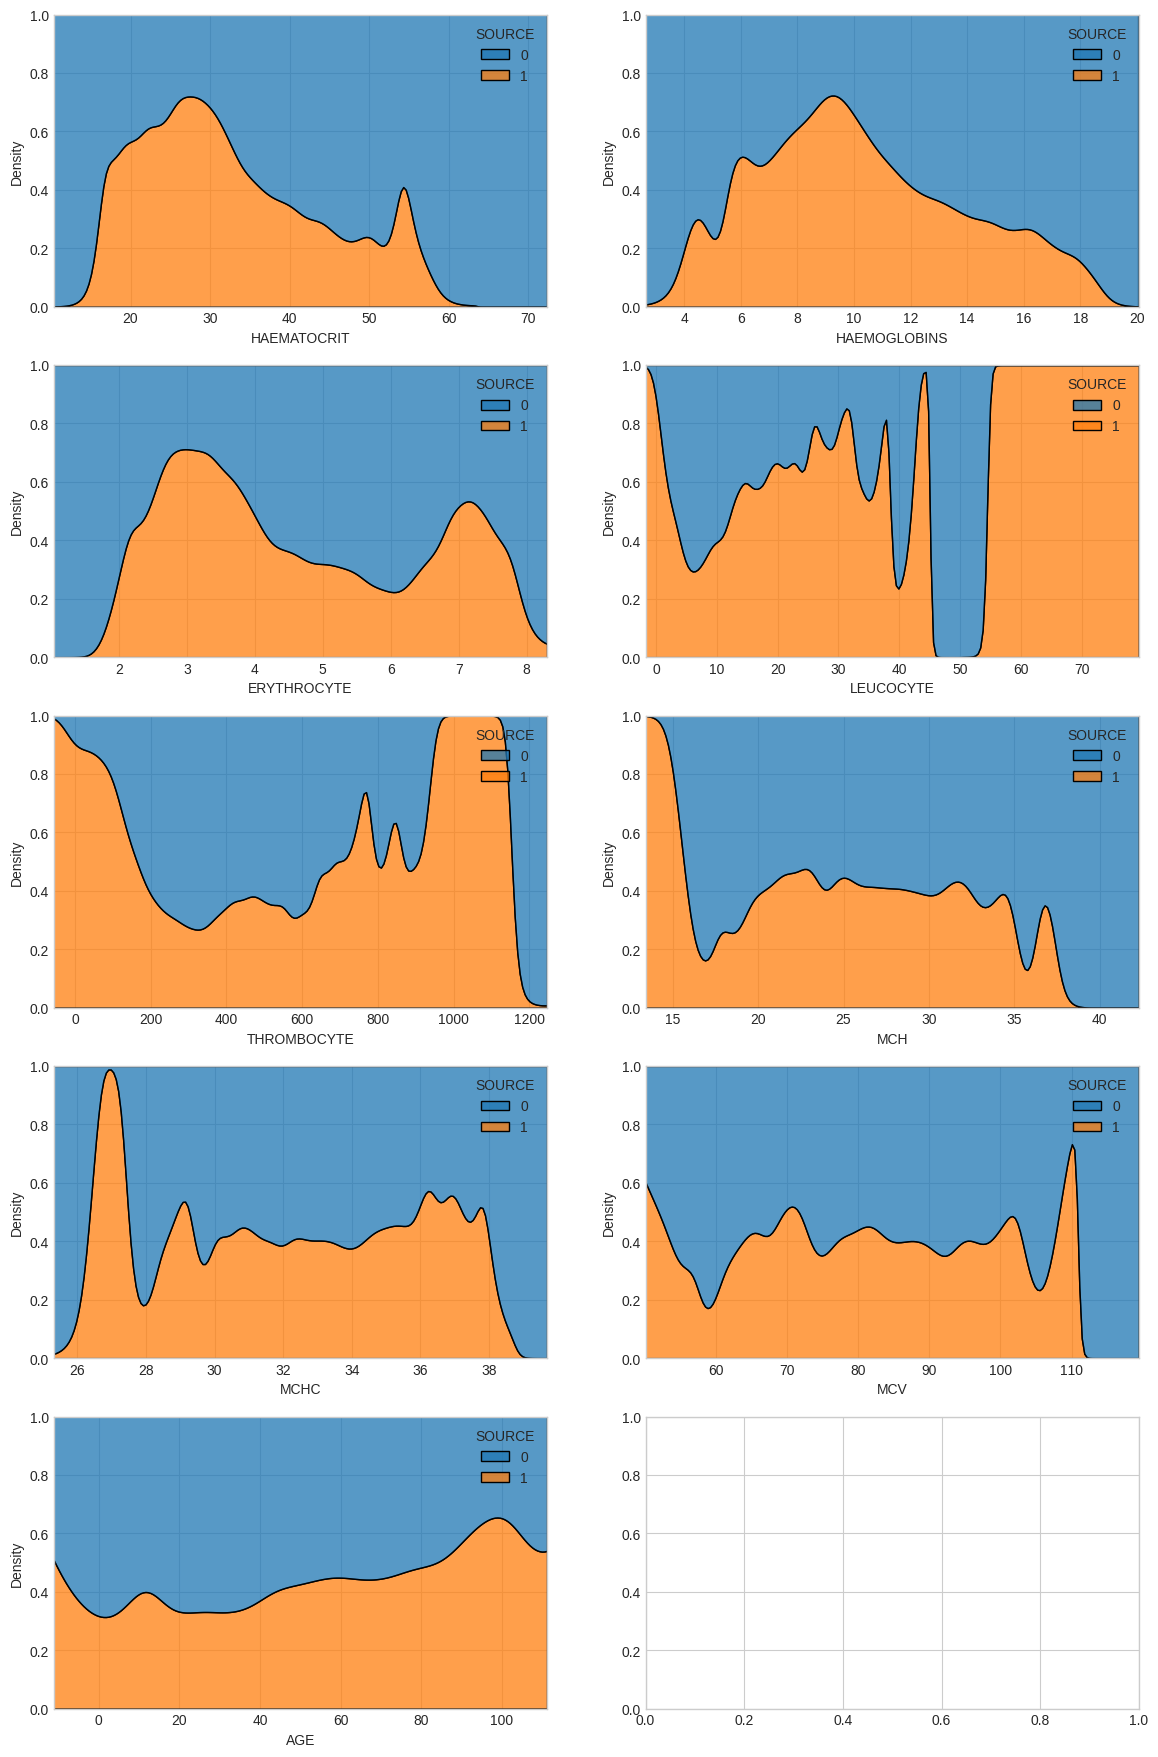

In [13]:
# KDEplot for each numerical feature w.r.t target

fig, axes = plt.subplots(5,2, figsize=(14,22))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    plot = sns.kdeplot(data=data, x=c, hue='SOURCE', multiple='fill', ax=axes[i])

#### Bar plot

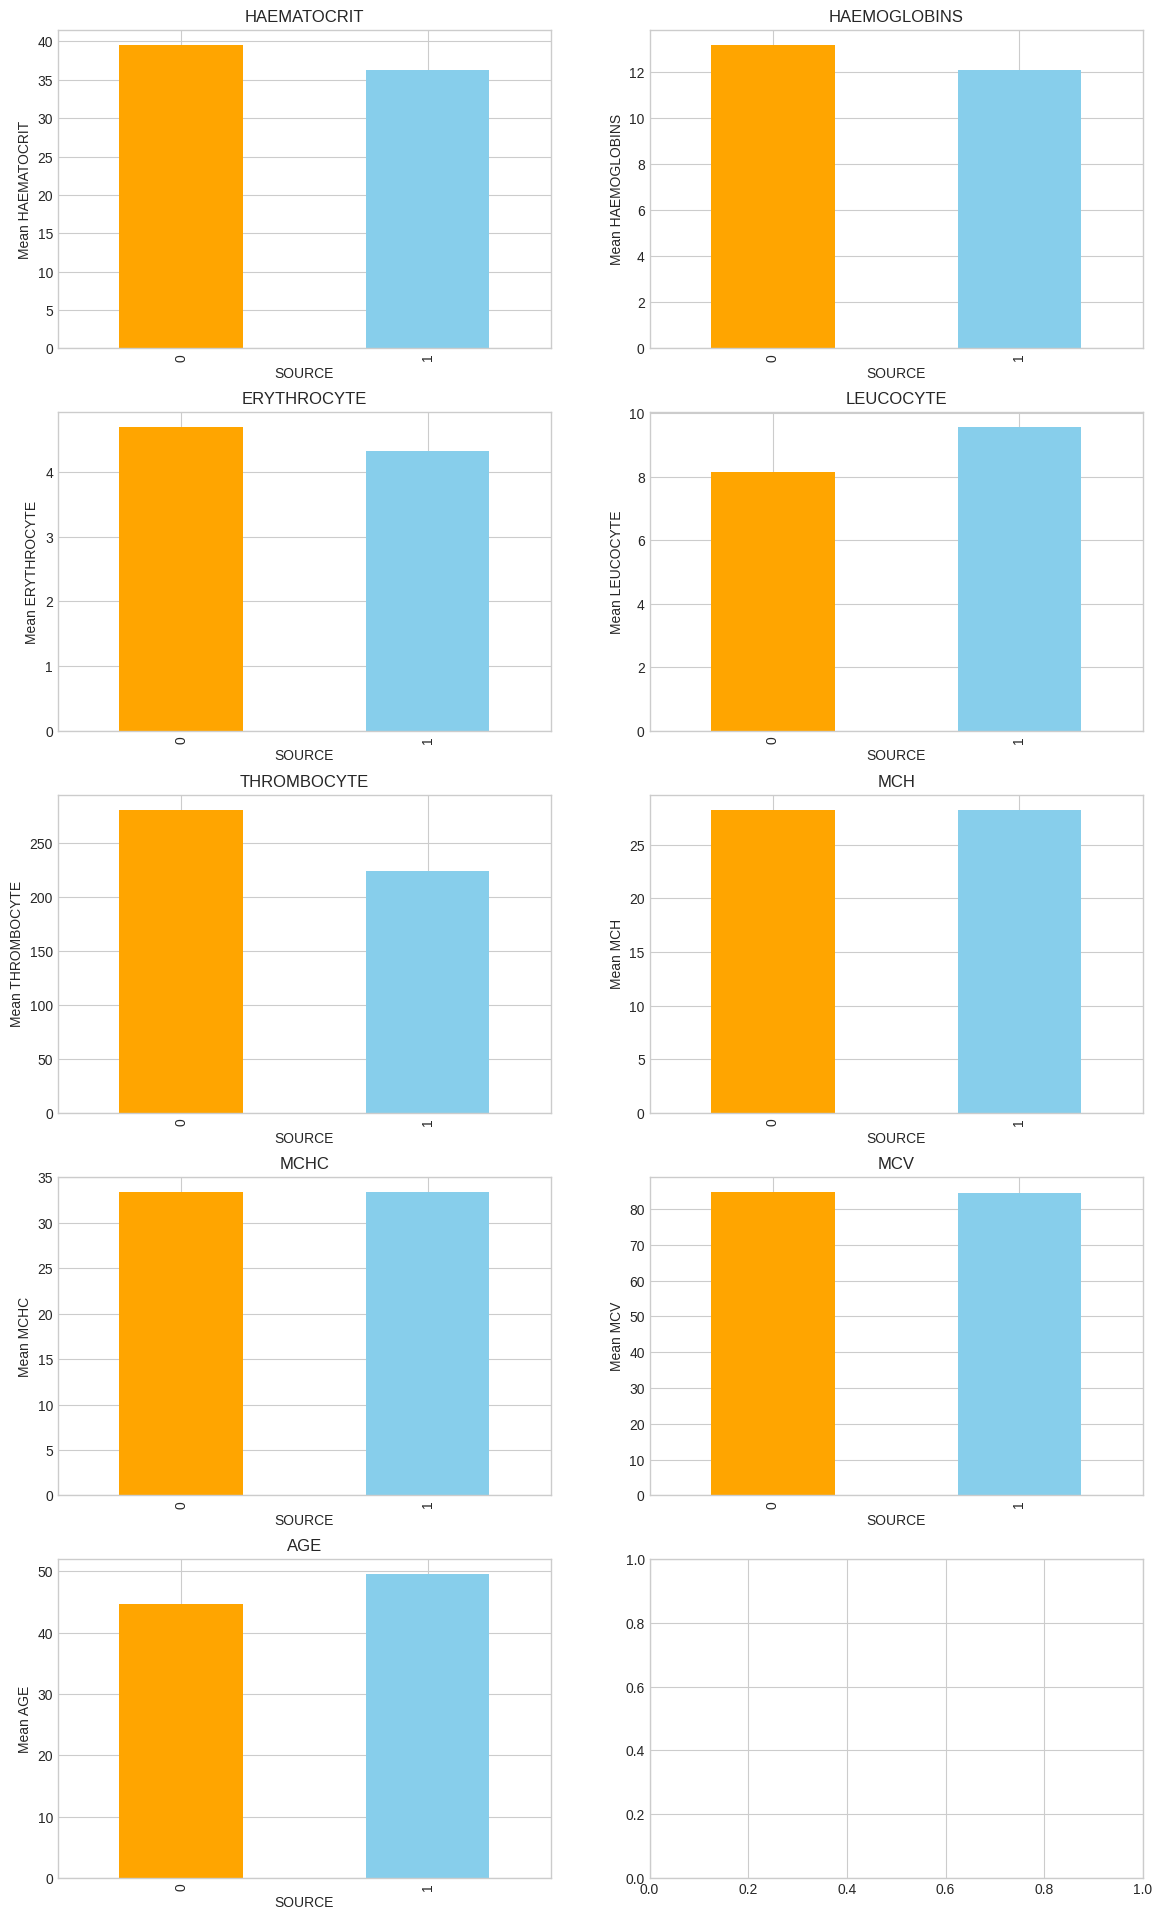

In [14]:
# Relationship between target and mean of each numerical features

fig, axes = plt.subplots(5,2, figsize=(14,24))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    df = data.groupby("SOURCE")[c].mean()
    plot = df.plot(kind='bar', title=c, ax=axes[i], ylabel=f'Mean {c}', color=('orange','skyblue'))

Observations:
- On average, The quantity of HAEMOTOCRIT, HAEMOGLOBINS, ERYTHROCYTE, and THROMBOCYTE features are lesser in In care patients.
- MCH, MCHV, MCV are less informative to differentiate classes
- The mean age of Incare patients is greater than the Outcare patients.

#### Correlation - matrix

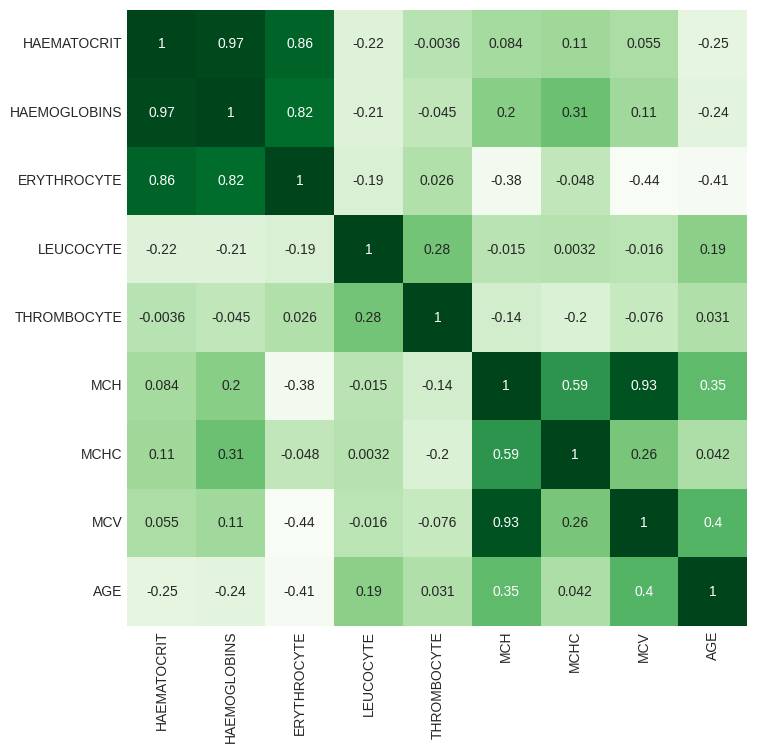

In [15]:
# Pearson Correlation of features w.r.t each other

corr_matt = data[num_features].corr(method='pearson')
plt.figure(figsize=(8,8))
corr = sns.heatmap(corr_matt, annot=True, cmap='Greens', cbar=False)

Observations:
- LEUCOCYTE and AGE are postively correlated with target
- THROMBOCYTE, ERYTHROCYTE, HAEMOGLOBINS and HAEMATOCRIT are negatively correlated with target
- No notable correlation found between MCHC, MCH, MCV, and target

### Categorical feature(s)

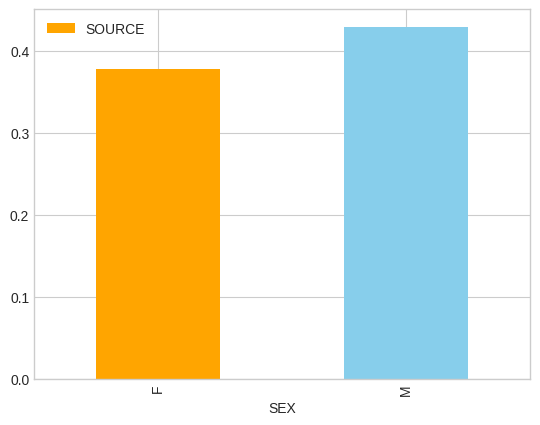

In [17]:
# Mean of target==1 w.r.t SEX

df = data.groupby('SEX')['SOURCE'].mean().to_frame().reset_index()
plot = df.plot(kind='bar', x='SEX', y='SOURCE', color=('orange', 'skyblue'))

Observation:
- Male Incare patients are more in number than Female Incare patients

# Feature Engineering

### Label encoding

In [23]:
# Replace labels of SEX with binary numbers

X_train.SEX.replace({'F':0, 'M':1}, inplace=True)
X_test.SEX.replace({'F':0, 'M':1}, inplace=True)

### Feature Scaling

Transform all the numerical features into a range [0, 1]

In [18]:
# MinMaxScaler will scale the features to a range of [0, 1]

scaler = MinMaxScaler(feature_range=(0, 1))

X_train[num_features] = scaler.fit_transform(X_train[num_features]) #fit and transform the train set
X_test[num_features] = scaler.transform(X_test[num_features]) #transform the test test

In [19]:
# preprocessed data

X_train.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX
2902,0.594595,0.675497,0.504702,0.052980,0.139574,0.575290,0.684615,0.508117,0.591837,M
1282,0.373874,0.403974,0.330721,0.213245,0.233191,0.490347,0.515385,0.493506,0.316327,F
2571,0.295045,0.337748,0.329154,0.075497,0.001702,0.386100,0.553846,0.339286,0.540816,F


# Feature selection
In exploratory data analysis, we found out that the features MCH, MCHC and MCV are not very useful in predicting the target. Let's remove those features.

In [20]:
# Remove least correlated features [MCH, MCHC, MCV]

X_train.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)
X_test.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)

# final train set
X_train.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,AGE,SEX
2902,0.594595,0.675497,0.504702,0.052980,0.139574,0.591837,M
1282,0.373874,0.403974,0.330721,0.213245,0.233191,0.316327,F
2571,0.295045,0.337748,0.329154,0.075497,0.001702,0.540816,F


# Machine Learning

### Decision Tree Classifier

In [24]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, tree.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, tree.predict(X_test)))

Train accuracy :  1.0
Test accuracy :  0.681766704416761


#### Hyperparameter tuning of Decision tree classifier

In [25]:
# Hyperparameters
distribution = {'max_depth': [4, 6, 8, 10, 12, 14, 16],
                'criterion': ['gini', 'entropy'],
                'min_samples_split': [2, 10, 20, 30, 40],
                'max_features': [0.2, 0.4, 0.6, 0.8, 1],
                'max_leaf_nodes': [8, 16, 32, 64, 128,256],
                'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
               }

# Random search for best hyperparameters
search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1),
                         distribution,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)

search.fit(X_train, y_train)

# Best parameters for DT classifier
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'min_samples_split': 2,
 'max_leaf_nodes': 8,
 'max_features': 0.6,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': {0: 1, 1: 2}}

In [26]:
# Retrain with best model

best_tree = search.best_estimator_

best_tree.fit(X_train, y_train)
print(" Best train accuracy : ", accuracy_score(y_train, best_tree.predict(X_train)))
print(" Best test accuracy : ", accuracy_score(y_test, best_tree.predict(X_test)))

 Best train accuracy :  0.7169169736469255
 Best test accuracy :  0.6783691959229898


In [27]:
print(classification_report(y_test, best_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       526
           1       0.59      0.66      0.63       357

    accuracy                           0.68       883
   macro avg       0.67      0.68      0.67       883
weighted avg       0.69      0.68      0.68       883



### Logistic regression

In [28]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, logreg.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, logreg.predict(X_test)))

Train accuracy :  0.7169169736469255
Test accuracy :  0.7089467723669309


#### Hyperparameter tuning for Logistic regression

In [29]:
# Hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'fit_intercept':[True, False],
              'max_iter':[100, 200, 300],
              'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 5}]
             }

# Random search for best hyperparameters
search = RandomizedSearchCV(LogisticRegression(random_state=1),
                         param_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)

search.fit(X_train, y_train)

# Best parameters for Logistic regression classifier
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'penalty': 'l2',
 'max_iter': 100,
 'fit_intercept': True,
 'class_weight': {0: 1, 1: 1},
 'C': 1}

In [30]:
# Retrain with best model

best_logreg = search.best_estimator_

best_logreg.fit(X_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_logreg.predict(X_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_logreg.predict(X_test)))

Best train accuracy :  0.7169169736469255
Best test accuracy :  0.7089467723669309


In [31]:
print(classification_report(y_test, best_logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       526
           1       0.72      0.46      0.56       357

    accuracy                           0.71       883
   macro avg       0.71      0.67      0.67       883
weighted avg       0.71      0.71      0.69       883



### Support Vector Classifier

In [32]:
svc = SVC(random_state=1)

svc.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, svc.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, svc.predict(X_test)))

Train accuracy :  0.7557381694531029
Test accuracy :  0.7180067950169875


#### Hyperparameter tuning - Support vector classifier

In [33]:
# Hyperparameters
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'poly'],
              'degree':[0, 1, 2, 3, 4, 5, 6]
             }

# Random search for best hyperparameters
search = RandomizedSearchCV(SVC(random_state=1),
                         param_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)

search.fit(X_train, y_train)

# Best parameters for Support vector classifier
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'kernel': 'rbf', 'gamma': 1, 'degree': 4, 'C': 100}

In [34]:
# Retrain with best model

best_svc = search.best_estimator_

best_svc.fit(X_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_svc.predict(X_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_svc.predict(X_test)))

Best train accuracy :  0.768206290733919
Best test accuracy :  0.7338618346545867


In [35]:
print(classification_report(y_test, best_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       526
           1       0.72      0.56      0.63       357

    accuracy                           0.73       883
   macro avg       0.73      0.71      0.71       883
weighted avg       0.73      0.73      0.73       883



### Random forest classifer

In [36]:
forest = RandomForestClassifier(random_state=1)

forest.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, forest.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, forest.predict(X_test)))

Train accuracy :  1.0
Test accuracy :  0.7406568516421291


#### Hyperparameter tuning - Random forest classifier

In [37]:
# Hyperparameters
params_grid = {'bootstrap': [True, False],
             'max_depth': [2, 5, 10, 20, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [50, 100, 150, 200]}

# Random search for best hyperparameters
search = RandomizedSearchCV(RandomForestClassifier(random_state=1),
                         params_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=20)

search.fit(X_train, y_train)

# Best parameters for Random forest classifier
search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [38]:
# Retrain with best model

best_forest = search.best_estimator_

best_forest.fit(X_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_forest.predict(X_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_forest.predict(X_test)))

Best train accuracy :  1.0
Best test accuracy :  0.7417893544733862


In [39]:
print(classification_report(y_test, best_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       526
           1       0.71      0.61      0.65       357

    accuracy                           0.74       883
   macro avg       0.73      0.72      0.72       883
weighted avg       0.74      0.74      0.74       883



### Stacking classifier
Combine all the best models

In [40]:
stack = StackingClassifier(estimators=[('best tree classifier', best_tree),
                                       ('best logreg', best_logreg),
                                       ('best svc', best_svc),
                                       ('best forest classifier', best_forest)],

                           final_estimator=LogisticRegression(),
                           passthrough=True)

stack.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, stack.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, stack.predict(X_test)))

Train accuracy :  0.8977047322187589
Test accuracy :  0.7281993204983013


In [41]:
print(classification_report(y_test, stack.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       526
           1       0.70      0.58      0.63       357

    accuracy                           0.73       883
   macro avg       0.72      0.70      0.71       883
weighted avg       0.72      0.73      0.72       883



## Save the final pipeline

In [42]:
# final features
features = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'AGE', 'SEX']
num_features = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'AGE']

X = data[features] # feature set
y = data['SOURCE'] # target

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Label encoding
X_train.SEX.replace({'M':1, 'F':0}, inplace=True)
X_test.SEX.replace({'M':1, 'F':0}, inplace=True)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Train the final model again!
model = StackingClassifier(estimators=[('best tree classifier', best_tree),
                                       ('best logreg', best_logreg),
                                       ('best svc', best_svc),
                                       ('best forest classifier', best_forest)],

                           final_estimator=LogisticRegression(),
                           passthrough=True)

model.fit(X_train, y_train)
print("Final model trained Successfully!")

# Pickle scaler object
with open("scaler.pkl", 'wb') as file:
    pickle.dump(scaler, file)

# Pickle model object
with open("model.pkl", 'wb') as file:
    pickle.dump(model, file)

print("Pickled and Saved Successfully!")

Final model trained Successfully!
Pickled and Saved Successfully!
